In [5]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
from examples.ista import sol_2_obj_diff
import time
import jax.numpy as jnp
import scs
import numpy as np
from scipy.sparse import csc_matrix
from l2ws.algo_steps import k_steps_eval, k_steps_train_ista, create_projection_fn, lin_sys_solve, k_steps_train_fista
import jax.scipy as jsp
import pytest
import matplotlib.pyplot as plt
from l2ws.ista_model import ISTAmodel
import cvxpy as cp
from jax import vmap
from functools import partial
from examples.ista import generate_b_mat
from scipy.spatial import distance_matrix
from examples.ista import sol_2_obj_diff, solve_many_probs_cvxpy
from l2ws.utils.nn_utils import get_nearest_neighbors
import numpy as np
# from tensorflow.keras.datasets import mnist
# import cv2
import gzip

In [6]:
import urllib.request
import os

# Create directory to store MNIST dataset
if not os.path.exists('mnist_data'):
    os.makedirs('mnist_data')

# Download training set images and labels
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
                           'mnist_data/train-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
                           'mnist_data/train-labels-idx1-ubyte.gz')

# Download test set images and labels
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
                           'mnist_data/t10k-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
                           'mnist_data/t10k-labels-idx1-ubyte.gz')

('mnist_data/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x297703190>)

In [7]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

# Load MNIST dataset
x_train, y_train = load_mnist('mnist_data', kind='train')
x_test, y_test = load_mnist('mnist_data', kind='t10k')

# Normalize pixel values
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

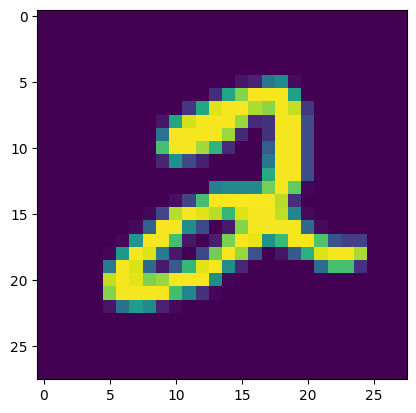

In [149]:
x_train.shape
x_train_img = np.reshape(x_train, (60000, 28, 28))
plt.imshow(x_train_img[5,:,:])#, cmap='gray')
import scipy.linalg as la

c = np.zeros(28)
s = 2
c[:s] = (s - np.arange(0,s))/(3*s)
blur_matrix = la.toeplitz(c)

# # Define blur filter size
# blur_size = 3

# # Define blur filter matrix
# blur_filter = np.ones((blur_size, blur_size)) / (blur_size ** 2)
# blur_filter[1, 1] = 10
# blur_filter = blur_filter / blur_filter.sum()


# # Reshape filter matrix to 1D vector
# blur_filter = blur_filter.reshape(-1)

# # Create blur matrix for MNIST images
# blur_matrix = np.zeros((28, 28))

# for i in range(28):
#     for j in range(28):
#         if abs(i - j) < blur_size ** 2:
#             blur_matrix[i, j] = blur_filter[abs(i - j)]

blur_matrix_kron = np.kron(blur_matrix, blur_matrix)

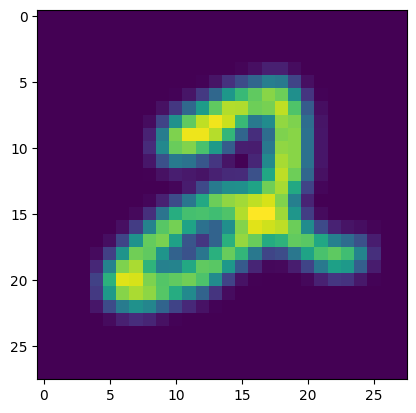

In [150]:
blurred_vec = blur_matrix_kron @ x_train[5,:]
blurred_img = np.reshape(blurred_vec, (28, 28))
plt.imshow(blurred_img)

finished solving cvxpy problems


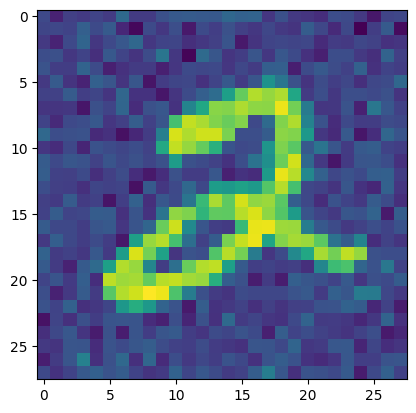

In [172]:
# deblur
lambd = 1e5
mask = np.random.binomial(1, .1, size=(10, 784))
noise = 1*np.random.normal(size=(10, 784))
b_mat = x_train[:10, :] + noise
# x_stars, objvals = solve_many_probs_cvxpy(blur_matrix_kron, b_mat, lambd)
x_stars, objvals = solve_many_probs_cvxpy(np.eye(784), b_mat, lambd)

# blurred_vec = blur_matrix_kron @ x_train[2,:]
recovered_img = np.reshape(x_stars[5, :], (28, 28))
plt.imshow(np.reshape(b_mat[5,:], (28, 28)))


# evals, evecs = np.linalg.eigh(blur_matrix_kron.T @ blur_matrix_kron)

# print(evals)


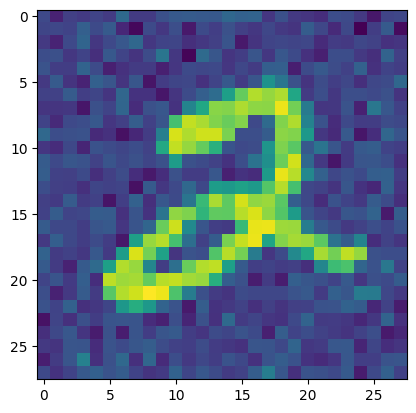

In [173]:
plt.imshow(recovered_img)

In [7]:
# create l2ws_model
# nn_cfg = {'lr': 1e-5} 
nn_cfg = {}
# nn_cfg = {'intermediate_layer_sizes': [200]} #, 'lr': 1e-1}
train_unrolls = 50
input_dict = dict(algorithm='ista',
                    supervised=False,
                    train_unrolls=train_unrolls, 
                    jit=True,
                    train_inputs=train_inputs, 
                    test_inputs=test_inputs,
                    b_mat_train=b_mat_train, 
                    b_mat_test=b_mat_test,
                    lambd=lambd,
                    ista_step=ista_step,
                    A=A,
                    nn_cfg=nn_cfg,
                    z_stars_train=z_stars_train,
                    z_stars_test=z_stars_test,
                    )
l2ws_model = ISTAmodel(input_dict)

In [8]:
# full evaluation on the test set with nearest neighbor
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = l2ws_model.evaluate(k, nearest_neighbors_z, b_mat_test, z_stars=z_stars_test, fixed_ws=True, tag='test')
nn_z_all = nn_eval_out[1][3]
nn_rel_objs = batch_rel_mat(nn_z_all, b_mat_test, objvals_test).mean(axis=1)
nn_losses = nn_eval_out[1][1].mean(axis=0)

# evaluate test before training
init_test_loss, init_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
init_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)
init_z_all = init_eval_out[1][3]
init_rel_objs = batch_rel_mat(init_z_all, b_mat_test, objvals_test).mean(axis=1)

distances [[11.28595094 10.19955971 12.08221381 ... 10.73967427 10.40359024
  11.02370339]
 [11.154609   11.10055938 11.38638715 ...  9.59148402 11.0870724
  11.49522852]
 [10.76148637 10.10169411 10.0070559  ... 10.02443974 11.86219263
  10.03742729]
 ...
 [ 8.22071553  9.78708547 10.98012113 ...  9.80395687  9.44522792
  10.46375583]
 [ 9.69722139 10.7477999  11.77437525 ...  9.29833084 10.07201084
  11.01006088]
 [ 9.70197362 10.62003826 11.64602543 ... 10.1199711  10.73180157
   9.15643014]]
indices [ 8 72  5 83 45 83 42 45 42 33 10 39 39 51 27 47  8 70 89 61]
best val [8.24069148 8.49276924 8.76464832 8.00707777 8.39094557 8.48057409
 8.13411354 7.54711438 7.87090907 7.76695723 8.72316557 7.33980079
 8.26248121 7.59932524 8.26009263 8.53822742 7.89090573 7.2178491
 8.35122036 7.58625515]


In [9]:
# call train_batch without jitting
params, state = l2ws_model.params, l2ws_model.state
num_epochs = 1000
losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = l2ws_model.train_full_batch(params, state)
    loss, params, state = train_result
    losses = losses.at[i].set(loss)

l2ws_model.params, l2ws_model.state = params, state

In [10]:
# evaluate test after training
final_test_loss, final_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
final_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_z_all = final_eval_out[1][3]
final_rel_objs = batch_rel_mat(final_z_all, b_mat_test, objvals_test).mean(axis=1)

final_test_losses = final_eval_out[1][1].mean(axis=0)

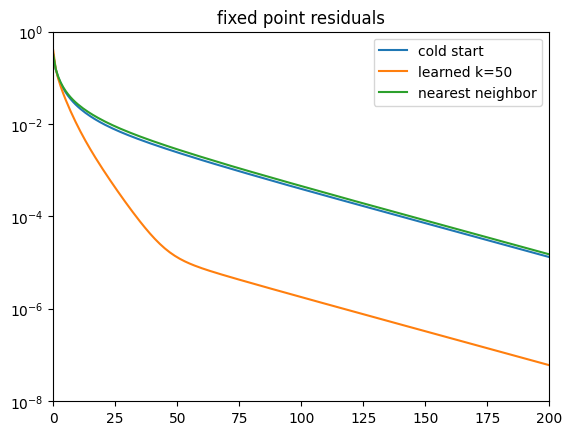

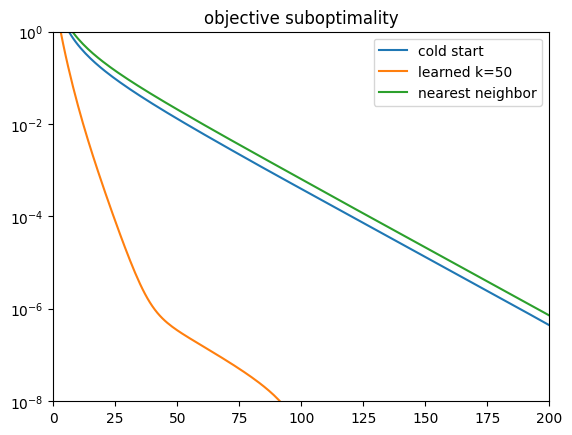

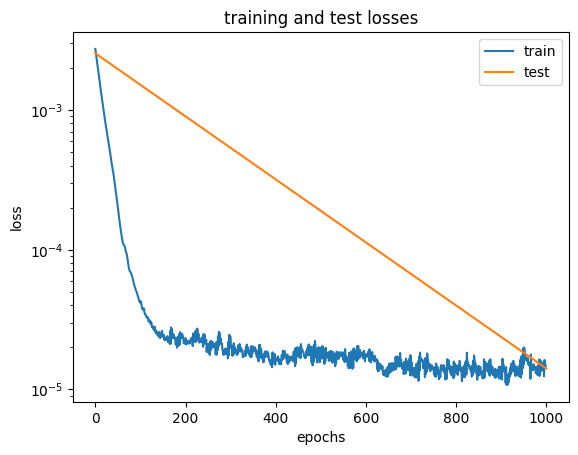

In [16]:
plt.plot(init_test_losses, label='cold start')
plt.plot(final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(nn_losses, label='nearest neighbor')
plt.yscale('log')
# plt.xscale('log')
plt.xlim((0,200))
plt.ylim((1e-8,1))
plt.title('fixed point residuals')
plt.legend()
plt.show()

plt.plot(init_rel_objs, label='cold start')
plt.plot(final_rel_objs, label=f"learned k={train_unrolls}")
plt.plot(nn_rel_objs, label='nearest neighbor')
plt.yscale('log')
# plt.xscale('log')
plt.xlim((0,200))
plt.ylim((1e-8,1))
plt.title('objective suboptimality')
plt.legend()
plt.show()

plt.plot(losses, label='train')
test_losses = np.array([init_test_loss, final_test_loss])
epochs_array = np.array([0, num_epochs])
plt.plot(epochs_array, test_losses, label='test')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.title('training and test losses')
plt.legend()
plt.show()

In [ ]:
# get accuracies for certain metrics